In [1]:
import requests
import pandas as pd
import os
import json
import datetime
from datetime import datetime, timedelta, date
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
load_dotenv()

import warnings
warnings.filterwarnings("ignore")

In [2]:
#function to pull data from systradingmarketdata
#https://systradingmarketdataapi.azurewebsites.net/index.html
#start_Date and end_date are required parameters unlike what is stated in Swagger

def get_marketdata_ag(as_of_date, start_datetime, end_datetime, analysis_group, curve_name):
    #define the basic parameters of the API call
    baseurl = "https://systradingmarketdataapi.azurewebsites.net/api/"
    url = f"{baseurl}Authentication/request"
    
    payload=f'{{"username": "{os.getenv("MARKETDATA_USER")}", "password": "{os.getenv("MARKETDATA_PWD")}"}}'
    headers = {
      'Authorization': '',
      'Content-Type': 'application/json',
    }
    
   # get the token
    login_response = requests.request("POST", url, headers=headers, data=payload)
    #print(login_response.text)

    #params = f"asOfDate={as_of_date}&granularity=hours&timeZone=GMT"
    params = f"start={start_datetime}&end={end_datetime}&asOfDate={as_of_date}&granularity=hours&timeZone=GMT"
    group_url = f'{baseurl}AnalysisGroup/{analysis_group}/{curve_name}?{params}'
    #print(group_url)

    payload={}
    headers = {
      'Authorization': f'Bearer {login_response.text}',
    }
    #print(group_url)
    response = requests.request("GET", group_url, headers=headers, data=payload)
    #print(response.text)

    power_json = json.loads(response.text)
    #print(power_json)

    # loading hour sequence from the maximum and minimum found - it's not yet clear
    # the logic for the cut off date times.
    max_found_time = max([x['timeSeries'][-1]['date'] for x in power_json['curves']])
    min_found_time = min([x['timeSeries'][0]['date'] for x in power_json['curves']])

    hour_sequence = pd.date_range(start = pd.to_datetime(min_found_time),
                             end = pd.to_datetime(max_found_time),
                             freq = "H")

     # %%
    # create named dataframe from json
    def turn_series_to_df(json_series):
        this_df = pd.DataFrame.from_records(json_series['timeSeries'])
        this_df['date'] = pd.to_datetime(this_df['date'])
        this_df.set_index('date', inplace=True)
        this_df.rename(columns={'value' : json_series['memberName']}, inplace=True)#'name' is an alternative here to memberName
        return(this_df)

    # %%
    # load initial dataset for first time series and fill mising hours

    power_df = turn_series_to_df(power_json['curves'][0])
    power_df = power_df.reindex(hour_sequence)
    power_df.rename_axis("date", axis='index', inplace=True)

    # %%

    for full_series in power_json['curves'][1:]:
        this_df = turn_series_to_df(full_series)
        power_df = pd.merge(power_df,this_df,how='left', left_index=True, right_index=True)                            
    return power_df

In [3]:
#re-format the output of the previous function
def reformat (ce):
    ce = ce.resample(rule='24H', closed='left', label='left', base=5).mean().round(1)
    ce = ce.iloc[:-1,:]
    ce['date'] = ce.apply(lambda x: datetime(x.name.year, x.name.month, x.name.day), axis = 1)
    ce = ce.set_index('date')
    ce=ce.rename(columns={ce.columns[0]:'Temp_fcst'})
    return ce

In [4]:
#Pull the data and produce the forecast
end = (datetime.today() + timedelta(days = 15)).replace(hour = 0, minute = 0, second=0, microsecond=0)
start = datetime.today().replace(hour = 5, minute = 0, second=0, microsecond=0)
asof = (datetime.today()).replace(hour = 3, minute = 0, second=0, microsecond=0)

fcst = get_marketdata_ag(asof, start, end, 'weather_CEE', 'ModelAPI.MAGMA.Kyiv.Temperature.Hourly.UTC')
fcst = reformat(fcst)

In [5]:
#Pull the previous weather forecast
if datetime.today().weekday() == 0:
   daysdelta = -3
else:
    daysdelta = -1

end1 = end + timedelta(days = daysdelta)
start1 = start + timedelta(days = daysdelta)
asof1 = asof + timedelta(days = daysdelta)

fcst_prev = get_marketdata_ag(asof1, start1, end1, 'weather_CEE', 'ModelAPI.MAGMA.Kyiv.Temperature.Hourly.UTC')
fcst_prev = reformat(fcst_prev)

In [6]:
#Apply coefs
coefs = pd.read_csv('coef.csv')
slope = coefs['slope'].iloc[0]
inter = coefs['intercept'].iloc[0]

fcst['Current forecast'] = fcst['Temp_fcst'] * slope  + inter + 3.75
fcst['Current forecast'] = fcst['Current forecast'].round(1)

fcst_prev['Previous forecast'] = fcst_prev['Temp_fcst'] * slope  + inter + 3.75
fcst_prev['Previous forecast'] = fcst_prev['Previous forecast'].round(1)

In [7]:
#Prepare the output table
output = pd.concat([fcst, fcst_prev['Previous forecast']], axis = 1)


#Pull (adjusted) normal demand
normal = pd.read_csv('30_yr_av_demand.csv', index_col = 0)
normal.index = pd.to_datetime(normal.index, format='%d/%m/%Y')# format='%d%m%Y'
normal = normal.round(1)
normal = normal.rename(columns = {normal.columns[0]:'SND'})

output = pd.concat([output, normal], axis=1, join="inner")
output['Current forecast vs previous forecast'] = output['Current forecast'] - output['Previous forecast']
output['Current forecast vs seasonal normal demand'] = output['Current forecast'] - output['SND']

output = output.iloc[1:,:]
output.index = output.index.date

change1 = output['Current forecast vs previous forecast'].sum()
change2 = output['Current forecast vs seasonal normal demand'].sum()

output.loc['Total:'] =''
output.at['Total:', 'Current forecast vs previous forecast'] = change1
output.at['Total:', 'Current forecast vs seasonal normal demand'] = change2

In [8]:
fof = pd.DataFrame(output['Current forecast vs previous forecast'][:-2].astype(float))
fos = pd.DataFrame(output['Current forecast vs seasonal normal demand'][:-2].astype(float))

           Temp_fcst Current forecast Previous forecast    SND  \
2021-12-22     -12.2            136.0             128.4  116.1   
2021-12-23     -12.2            136.0             129.3  116.3   
2021-12-24      -2.2            115.6             115.0  116.4   
2021-12-25      -0.2            111.6             114.6  116.6   
2021-12-26      -5.5            122.3             120.1  116.8   
2021-12-27      -1.9            115.0             116.4  116.9   
2021-12-28      -0.6            112.4             115.2  117.1   
2021-12-29      -2.4            116.0             111.4  117.2   
2021-12-30      -5.9            123.2             113.6  117.3   
2021-12-31      -7.3            126.0             117.3  117.4   
2022-01-01      -6.8            125.0             118.3  117.5   
2022-01-02      -6.3            124.0             119.1  117.6   
2022-01-03      -6.1            123.6             120.1  117.7   
2022-01-04      -5.4            122.1               NaN  117.8   
Total:    

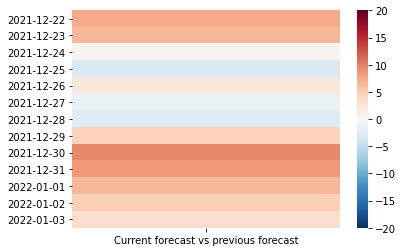

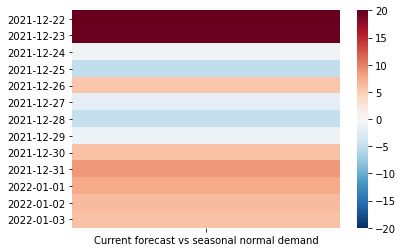

In [9]:
print(output)
print('Notes:')
print('1) SND - seasonal normal demand adjusted for demand destruction observed between 1 Nov and 15 Dec')
print('2) Previous forecast refers to the forecast generated on the previous business day')
sns.heatmap(fof,cmap='RdBu_r', vmin=-20, vmax=20)
plt.show()
sns.heatmap(fos,cmap='RdBu_r', vmin=-20, vmax=20)
plt.show()

In [11]:
if __name__ == '__main__':

    from reporting import *

    send_date = dt.date.today()

    html = """<br><p style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold">
    Notes:
                                </p><br>"""
    html += """<br><p style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold">
    1) SND - seasonal normal demand adjusted for demand destruction observed between 1 Nov and 15 Dec
                                </p><br>"""
    html += """<br><p style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold">
    2) Previous forecast refers to the forecast generated on the previous business day
                                </p><br>"""

    send_email_alert(subject='Testing email sent on %(send_date)s' % {'send_date':send_date}, distro='dev',
    input_1=output, description_1='Ukraline Gas Demand')  


Sending email alert completed ...
